## Timeseries clustering

Run VRAE with MRI data from tadpole, so that we know how to load data in it, and see that it works well. We use sequences of fixed size (n=5), and study how and if the networks make a good optimization or not, as well as studying how the decoder is working and if we should do some kind of sequence to sequence learning.


In [3]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error


In [4]:
# Parameters
hidden_size = 20
hidden_layer_depth = 1
latent_length = 5
learning_rate = 0.0005
n_epochs = 8000
dropout_rate = 0.0 # We have variational dropout in our implementation
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every = 1000
clip = True # options: True, False # Gradient Clipping
max_grad_norm = 5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'GRU' # options: LSTM, GRU

dload = './mri_model_dir' #download directory

In [5]:
# LOAD DATA
csv_path = "data/tadpole_mrionly.csv"
X_train, X_val = open_MRI_data(csv_path, train_set=0.8, n_followups=5, normalize=True)

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

#We define batch size as the full length
# To change this we would need to change structurally everything. Afternoon.
# batch_size = X_train.shape[0] #In our original paper, there is no batch size, all the optimization is done together
batch_size = len(X_train)

#Convert to torch
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

# open question: why do I need to use tensor dataset? makes no sense, right?


#Make sure that this dataset makes sense

(4570, 48)


Initialize VRAE, fit and evaluate

In [6]:
#We would like the batch size 
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

# Fit the model
vrae.fit(train_dataset)

print(vrae.encoder)
print(vrae.lmbd)
print(vrae.decoder)

/homedtic/gmarti/project/anaconda3/envs/dlnn2/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1000, loss = 106565.1016, recon_loss = 106561.1250, kl_loss = 3.9745
Average loss: 106565.1016
Epoch 2000, loss = 97631.5234, recon_loss = 97626.5938, kl_loss = 4.9279
Average loss: 97631.5234
Epoch 3000, loss = 95981.3125, recon_loss = 95976.1641, kl_loss = 5.1480
Average loss: 95981.3125
Epoch 4000, loss = 94932.1406, recon_loss = 94926.7812, kl_loss = 5.3629
Average loss: 94932.1406
Epoch 5000, loss = 94182.8906, recon_loss = 94177.3125, kl_loss = 5.5755
Average loss: 94182.8906
Epoch 6000, loss = 93265.5000, recon_loss = 93259.7109, kl_loss = 5.7929
Average loss: 93265.5000
Epoch 7000, loss = 92410.3594, recon_loss = 92404.2969, kl_loss = 6.0657
Average loss: 92410.3594
Epoch 8000, loss = 91644.8438, recon_loss = 91638.4844, kl_loss = 6.3587
Average loss: 91644.8438
Encoder(
  (model): GRU(40, 20)
)
Lambda(
  (hidden_to_mean): Linear(in_features=20, out_features=5, bias=True)
  (hidden_to_logvar): Linear(in_features=20, out_features=5, bias=True)
)
Decoder(
  (model): GRU(1, 

Evaluate results:
    * plot loss
    * compute a metric for the testing dataset

(8000,)
(183, 5, 40)
(183, 5, 40)
MSE over the train set: 0.6003479775975047
MSE over the test set: 0.725050652448383


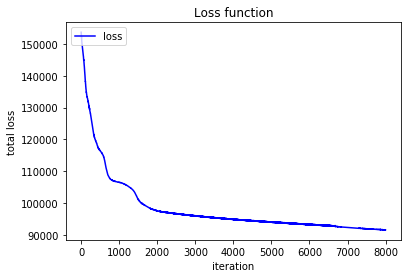

In [7]:
%matplotlib inline
# Plotting loss
# Get full curve from losss

import matplotlib.pyplot as plt

loss_curve = vrae.training_loss
print(np.array(loss_curve).shape)
#Plot it
plt.plot(range(len(loss_curve)), loss_curve, '-b', label='loss')

plt.xlabel("iteration")
plt.ylabel("total loss")

plt.legend(loc='upper left')
plt.title("Loss function")

# Transform the test dataset
X_hat_train = vrae.reconstruct(train_dataset)
X_hat = vrae.reconstruct(test_dataset)

# Need to reshape
X_hat = np.swapaxes(X_hat,0,1)
X_hat_train = np.swapaxes(X_hat_train,0,1)

print(X_hat.shape)
print(X_val.shape)

#Compute mean absolute error over all sequences
mse_test = np.mean([mean_absolute_error(xval, xhat) for (xval, xhat) in zip(X_train, X_hat_train)])
print('MSE over the train set: ' + str(mse_test))

#Compute mean absolute error over all sequences
mse_test = np.mean([mean_absolute_error(xval, xhat) for (xval, xhat) in zip(X_val, X_hat)])
print('MSE over the test set: ' + str(mse_test))

Text(0.5, 1.0, 'Predicted vs real')

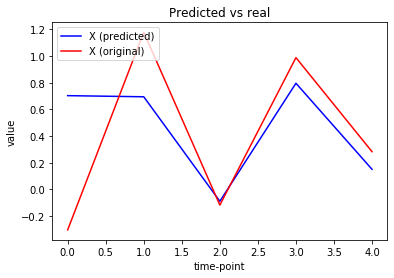

In [8]:
# Visualize the difference between X_test and X_hat for specific features and 
subject = 12
feature = 0

x_hat_curve = X_hat[subject, :, feature]
x_val_curve = X_val[subject, :, feature]

# Plot the two lines
plt.plot(range(len(x_hat_curve)), x_hat_curve, '-b', label='X (predicted)')
plt.plot(range(len(x_val_curve)), x_val_curve, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")


In [ ]:
# Visualize the difference between X_test and X_hat for a single subject, using the mean of the predictions and of all the features
subject = 13

x_hat_curve = np.mean(X_hat[subject, :, :], axis=1)
x_val_curve = np.mean(X_val[subject, :, :], axis=1)

# Plot the two lines
plt.plot(range(len(x_hat_curve)), x_hat_curve, '-b', label='X (predicted)')
plt.plot(range(len(x_val_curve)), x_val_curve, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")

In [8]:
# Visualize latent space

